In [1]:
import findspark
findspark.init('/home/ek/spark-2.4.4-bin-hadoop2.7')
import pyspark
import os
java8_location= '/usr/lib/jvm/java-8-openjdk-amd64' # Set your own
os.environ['JAVA_HOME'] = java8_location

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('HW').getOrCreate()
spark.conf.set('spark.sql.shuffle.partitions',6)

In [3]:
import numpy as np
from copy import deepcopy

In [4]:
RANDOM_HASH_FUNCTIONS = 1500 # K
N_SETS = 100
N_INITIAL = 20000
N_TOTAL = 10**5
PART_TO_REPLACE = int(N_INITIAL*(2./100))
PRIME_NR = 2**31 - 1 # P

In [5]:
all_numbers = np.arange(N_TOTAL,dtype = np.int32)
np.random.shuffle(all_numbers)

In [6]:
set_1 = all_numbers[:N_INITIAL]

In [7]:
left_overs = all_numbers[N_INITIAL:]

#### Create dataset

In [8]:
all_sets = [(0,np.sort(set_1))]
for i in range(1,N_SETS):
    random_idx = np.random.choice(np.arange(0, all_sets[i-1][1].shape[0], dtype = int),
                                  replace = False,
                                  size = PART_TO_REPLACE)

    new_set = deepcopy(all_sets[i-1][1])
    random_ints = np.random.randint(0,1e5,size = PART_TO_REPLACE)
    new_set[random_idx] = random_ints
    
    all_sets.append((i,np.unique(new_set)))

In [9]:
dataset = spark.sparkContext.parallelize([list(i) for i in all_sets])

In [10]:
random_integers  = [np.random.randint(0,100,size = 2)for _ in range(RANDOM_HASH_FUNCTIONS)]

In [11]:
random_integers = spark.sparkContext.broadcast(random_integers)

#### Hash the singles from 1 to N (32 bit int)

represent the sets which range from 0 to 1e5 as integers from 1 to N

In [12]:
def hash_shingles(x,N, random_integers, p): # a very basic hash just for the proof of concept
    return np.unique(((x*random_integers[0]+random_integers[1])%p)%N)+1

In [13]:
dataset_final = dataset.map(lambda x: (x[0],hash_shingles(x[1],N_TOTAL, (1,0), PRIME_NR)))

In [14]:
dataset_final_dict = dict(dataset_final.collect())

#### Compute the signature matrix

In [15]:
signature_matrix = dataset.map(lambda x: (x[0],np.array([np.min(hash_shingles(x[1],
                                                                     N_TOTAL,
                                                i,
                                                                    PRIME_NR))\
                                                for i in random_integers.value])))

In [16]:
signature_matrix.take(5)

[(0, array([13,  4,  3, ...,  3,  2, 13], dtype=int32)),
 (1, array([13,  4,  3, ...,  3,  2, 13], dtype=int32)),
 (2, array([13,  4,  3, ...,  3,  2, 13], dtype=int32)),
 (3, array([13,  4,  3, ...,  3,  2, 13], dtype=int32)),
 (4, array([13,  4,  3, ...,  3,  2, 13], dtype=int32))]

In [17]:
signature_matrix = dict(signature_matrix.collect())

In [18]:
S_1 = signature_matrix[0]

In [19]:
for key, value in signature_matrix.items():
    if key == 0:
        continue
    count = 0
    for i, s_ in enumerate(value):
        if s_==S_1[i]:
            count+=1
    print('MinHash similarity S_0:S_{}: {}'.format(key,count/RANDOM_HASH_FUNCTIONS))

MinHash similarity S_0:S_1: 0.9813333333333333
MinHash similarity S_0:S_2: 0.96
MinHash similarity S_0:S_3: 0.9413333333333334
MinHash similarity S_0:S_4: 0.912
MinHash similarity S_0:S_5: 0.8866666666666667
MinHash similarity S_0:S_6: 0.8753333333333333
MinHash similarity S_0:S_7: 0.8573333333333333
MinHash similarity S_0:S_8: 0.844
MinHash similarity S_0:S_9: 0.842
MinHash similarity S_0:S_10: 0.8246666666666667
MinHash similarity S_0:S_11: 0.8093333333333333
MinHash similarity S_0:S_12: 0.798
MinHash similarity S_0:S_13: 0.7833333333333333
MinHash similarity S_0:S_14: 0.768
MinHash similarity S_0:S_15: 0.744
MinHash similarity S_0:S_16: 0.734
MinHash similarity S_0:S_17: 0.7146666666666667
MinHash similarity S_0:S_18: 0.7073333333333334
MinHash similarity S_0:S_19: 0.6946666666666667
MinHash similarity S_0:S_20: 0.6986666666666667
MinHash similarity S_0:S_21: 0.6866666666666666
MinHash similarity S_0:S_22: 0.6786666666666666
MinHash similarity S_0:S_23: 0.6713333333333333
MinHash si

In [20]:
all_sets = dict(all_sets)
s_1 = all_sets[0]
print(s_1)
for key, value in all_sets.items():
    if key == 0:
        continue
    count = 0
    total = 0

    intersection = len(list(set(s_1).intersection(value)))
    union = (len(s_1) + len(value)) - intersection
    print('MinHash similarity S_0:S_{}: {}'.format(key,float(intersection) / union))

[    4     7     8 ... 99985 99996 99999]
MinHash similarity S_0:S_1: 0.9646161417322835
MinHash similarity S_0:S_2: 0.9311130502229978
MinHash similarity S_0:S_3: 0.8986967107461689
MinHash similarity S_0:S_4: 0.8688323917137476
MinHash similarity S_0:S_5: 0.8394614670380687
MinHash similarity S_0:S_6: 0.8120304196444933
MinHash similarity S_0:S_7: 0.7858079688842657
MinHash similarity S_0:S_8: 0.7616897630755476
MinHash similarity S_0:S_9: 0.738409864321386
MinHash similarity S_0:S_10: 0.7154840964697659
MinHash similarity S_0:S_11: 0.693221583790556
MinHash similarity S_0:S_12: 0.6730111206159111
MinHash similarity S_0:S_13: 0.6523616048755714
MinHash similarity S_0:S_14: 0.6332690534082335
MinHash similarity S_0:S_15: 0.614828660436137
MinHash similarity S_0:S_16: 0.5979907773386034
MinHash similarity S_0:S_17: 0.5809900828469984
MinHash similarity S_0:S_18: 0.5638319382101985
MinHash similarity S_0:S_19: 0.5488905829956265
MinHash similarity S_0:S_20: 0.5354324432044639
MinHash si

### Ex. 3

See the relation between the correct choice of parameters for locality sensitive hashing and the probability of false positives/ false negatives.

In [21]:
import matplotlib.pyplot as plt

In [22]:
jaccard_similarities = np.arange(0.1,1,step = 0.1)

In [23]:
row_numbers = np.array([2,3,5,7,20])
block_numbers = np.array([10,20,50,100])

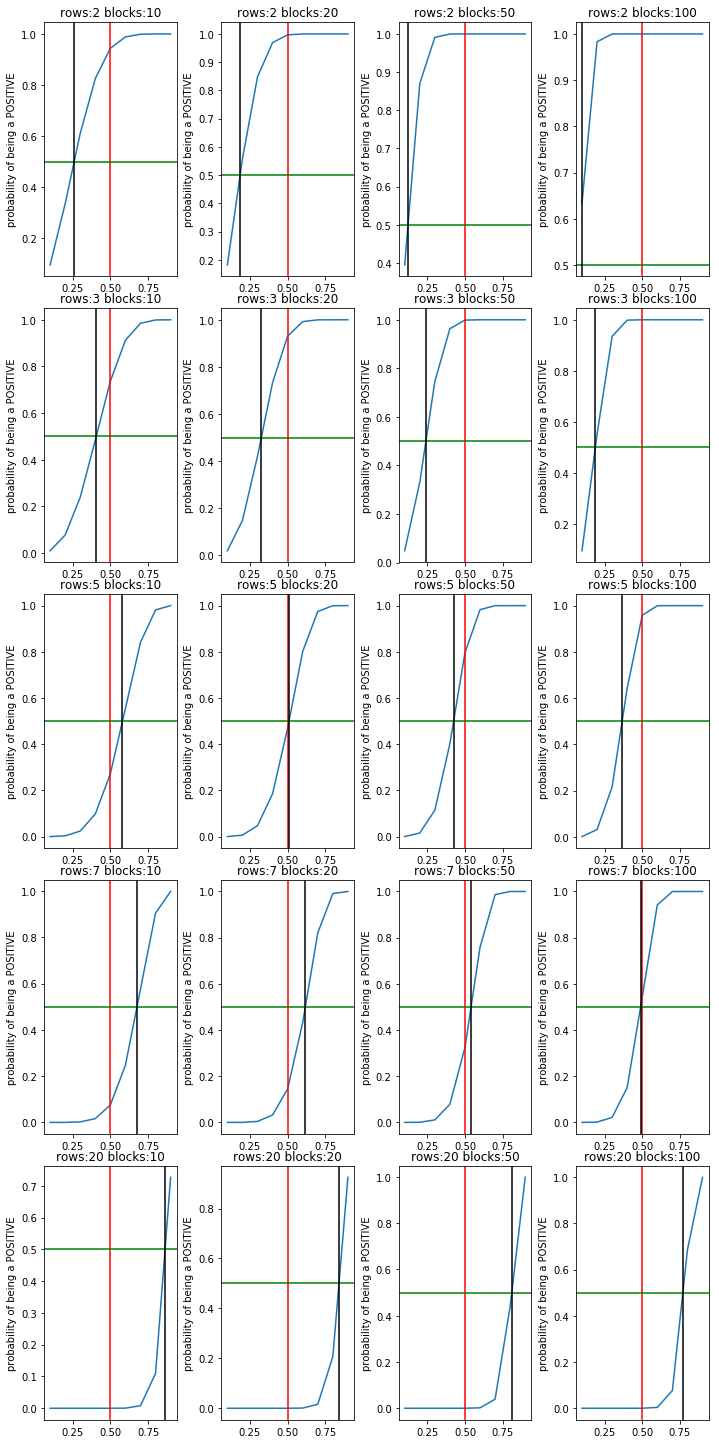

In [24]:
fig = plt.figure(figsize=(10,20))
ax = fig.subplots(5,4)
fig.tight_layout()
for i,row in enumerate(row_numbers):
    for j,block in enumerate(block_numbers):
        probabilities = 1-(1-jaccard_similarities**row)**block
        ax[i,j].plot(jaccard_similarities,probabilities)
        ax[i,j].set_title('rows:{} blocks:{}'.format(row,block))
        ax[i,j].set_ylabel('probability of being a POSITIVE')
        ax[i,j].axvline(x = 0.5,color = 'r')
        ax[i,j].axhline(y = 0.5,color = 'g')
        ax[i,j].axvline(x=np.interp(0.5,probabilities,jaccard_similarities),color='black')